In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd

# Load forecasted data for each asset
forecasted_tsla = pd.read_csv('/content/drive/MyDrive/forecasted_Tsla.csv', index_col='Date', parse_dates=True)
forecasted_bnd = pd.read_csv('/content/drive/MyDrive/Forecasts/forecasted_bnd.csv', index_col='Date', parse_dates=True)
forecasted_spy = pd.read_csv('/content/drive/MyDrive/Forecasts/forecasted_spy.csv', index_col='Date', parse_dates=True)

# Combine forecasted closing prices into a single DataFrame
df = pd.DataFrame({
    'TSLA': forecasted_tsla['ARIMA_Forecast'],
    'BND': forecasted_bnd['ARIMA_Forecast'],
    'SPY': forecasted_spy['ARIMA_Forecast']
})

# Display the combined DataFrame
df.head()

,TSLA,BND,SPY
Date,,,
2023-01-02 00:00:00+00:00,123.18,67.661557,374.297352
2023-01-03 00:00:00+00:00,123.18,67.632526,373.478848
2023-01-04 00:00:00+00:00,123.18,67.696232,373.939221
2023-01-05 00:00:00+00:00,123.18,67.748373,373.850245
2023-01-06 00:00:00+00:00,123.18,67.719594,373.601528


In [4]:
# Calculate daily returns
daily_returns = df.pct_change().dropna()

# Compute annualized returns assuming 252 trading days
annual_returns = daily_returns.mean() * 252

# Compute the covariance matrix for daily returns and annualize it
cov_matrix = daily_returns.cov() * 252

print("Annual Returns:\n", annual_returns)
print("\nCovariance Matrix:\n", cov_matrix)

Annual Returns:
 TSLA    0.000000
BND     0.000726
SPY    -0.001836
dtype: float64

Covariance Matrix:
       TSLA       BND       SPY
TSLA   0.0  0.000000  0.000000
BND    0.0  0.000006  0.000002
SPY    0.0  0.000002  0.000046


In [5]:
import numpy as np

# Define initial weights for TSLA, BND, and SPY
initial_weights = np.array([0.4, 0.3, 0.3])  # Adjust weights as desired

# Calculate portfolio return and volatility
portfolio_return = np.dot(initial_weights, annual_returns)
portfolio_volatility = np.sqrt(np.dot(initial_weights.T, np.dot(cov_matrix, initial_weights)))

print("Portfolio Expected Annual Return:", portfolio_return)
print("Portfolio Volatility (Risk):", portfolio_volatility)

Portfolio Expected Annual Return: -0.0003331656261661206
Portfolio Volatility (Risk): 0.0022563226704413126


In [6]:
from scipy.optimize import minimize

# Assume a risk-free rate for Sharpe Ratio calculation
risk_free_rate = 0.02  # e.g., 2% annual risk-free rate

# Define the function to minimize (negative Sharpe Ratio)
def neg_sharpe_ratio(weights):
    port_return = np.dot(weights, annual_returns)
    port_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratio = (port_return - risk_free_rate) / port_volatility
    return -sharpe_ratio  # Negative for minimization

# Constraints: weights sum to 1
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
# Bounds: Each weight is between 0 and 1
bounds = tuple((0, 1) for _ in range(len(initial_weights)))

# Optimization
optimized_result = minimize(neg_sharpe_ratio, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)
optimized_weights = optimized_result.x

print("Optimized Portfolio Weights:", optimized_weights)
print("Expected Portfolio Return with Optimized Weights:", np.dot(optimized_weights, annual_returns))
print("Expected Portfolio Volatility with Optimized Weights:", np.sqrt(np.dot(optimized_weights.T, np.dot(cov_matrix, optimized_weights))))


Optimized Portfolio Weights: [0. 0. 1.]
Expected Portfolio Return with Optimized Weights: -0.001836088357726688
Expected Portfolio Volatility with Optimized Weights: 0.006802119198271147


In [7]:
# Calculate Sharpe Ratio for optimized portfolio
optimized_return = np.dot(optimized_weights, annual_returns)
optimized_volatility = np.sqrt(np.dot(optimized_weights.T, np.dot(cov_matrix, optimized_weights)))
sharpe_ratio = (optimized_return - risk_free_rate) / optimized_volatility

# Calculate Value at Risk (VaR) for Tesla at a 95% confidence level
from scipy.stats import norm

confidence_level = 0.95
mean_return_tsla = daily_returns['TSLA'].mean()
std_dev_tsla = daily_returns['TSLA'].std()
VaR = norm.ppf(1 - confidence_level) * std_dev_tsla - mean_return_tsla

print("Optimized Sharpe Ratio:", sharpe_ratio)
print("Value at Risk (VaR) for TSLA at 95% Confidence Level:", VaR)

Optimized Sharpe Ratio: -3.2101890192216325
Value at Risk (VaR) for TSLA at 95% Confidence Level: -0.0


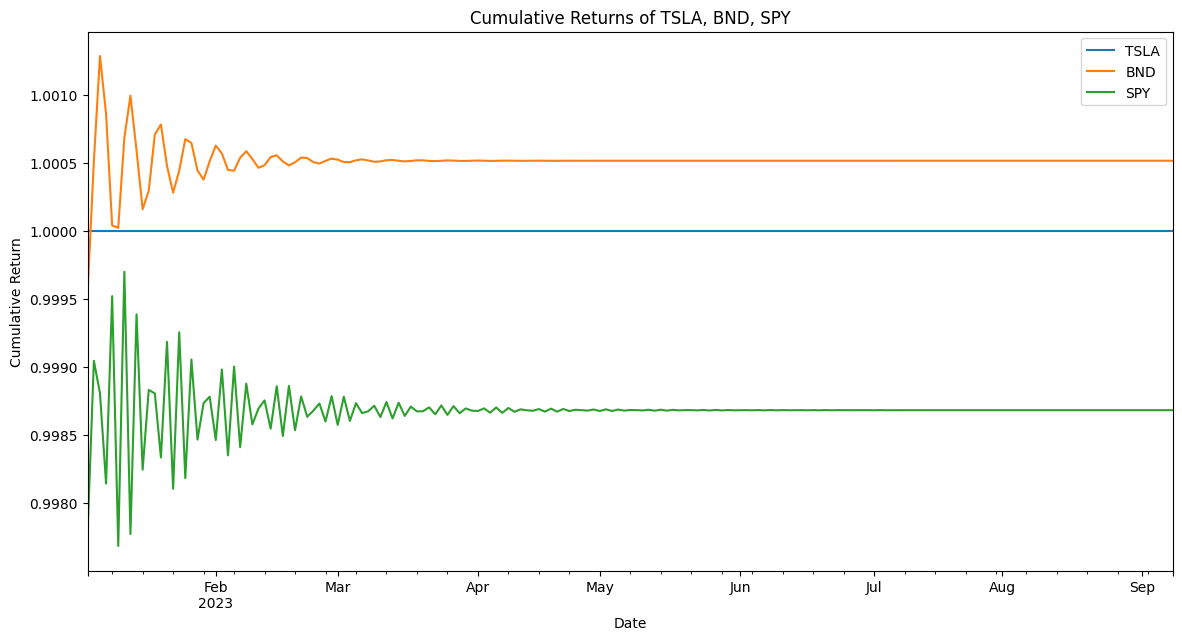

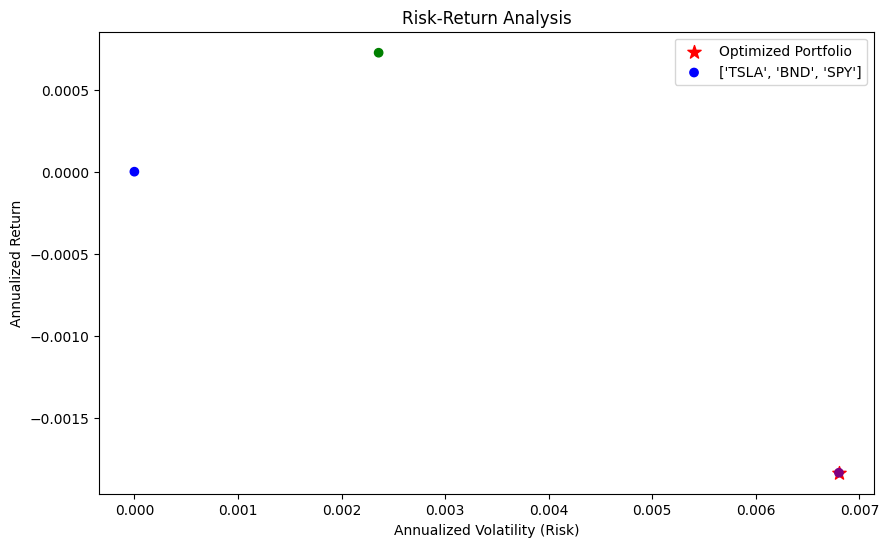

In [8]:
import matplotlib.pyplot as plt

# Cumulative Returns
cumulative_returns = (1 + daily_returns).cumprod()

# Plot cumulative returns
cumulative_returns.plot(figsize=(14, 7))
plt.title('Cumulative Returns of TSLA, BND, SPY')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.show()

# Risk-Return Scatter Plot
plt.figure(figsize=(10, 6))
plt.scatter(optimized_volatility, optimized_return, c='red', label='Optimized Portfolio', marker='*', s=100)
plt.scatter(daily_returns.std() * np.sqrt(252), annual_returns, c=['blue', 'green', 'purple'], label=['TSLA', 'BND', 'SPY'])
plt.xlabel('Annualized Volatility (Risk)')
plt.ylabel('Annualized Return')
plt.title('Risk-Return Analysis')
plt.legend()
plt.show()

# **Optimize Portfolio for LSTM Forecast**

In [9]:
# Combine forecasted closing prices into a single DataFrame
df = pd.DataFrame({
    'TSLA': forecasted_tsla['LSTM_Forecast'],
    'BND': forecasted_bnd['LSTM_Forecast'],
    'SPY': forecasted_spy['LSTM_Forecast']
})

# Display the combined DataFrame
df.head()

,TSLA,BND,SPY
Date,,,
2023-01-02 00:00:00+00:00,130.81690,68.457100,374.47928
2023-01-03 00:00:00+00:00,130.34950,68.374800,373.87420
2023-01-04 00:00:00+00:00,132.33865,68.347180,373.63367
2023-01-05 00:00:00+00:00,135.58380,68.348175,373.63570
2023-01-06 00:00:00+00:00,139.49382,68.364240,373.79870


In [10]:
# Calculate daily returns
daily_returns = df.pct_change().dropna()

# Compute annualized returns assuming 252 trading days
annual_returns = daily_returns.mean() * 252

# Compute the covariance matrix for daily returns and annualize it
cov_matrix = daily_returns.cov() * 252

print("Annual Returns:\n", annual_returns)
print("\nCovariance Matrix:\n", cov_matrix)

Annual Returns:
 TSLA    1.927701
BND     0.096943
SPY     0.222481
dtype: float64

Covariance Matrix:
           TSLA       BND       SPY
TSLA  0.018932 -0.000082  0.000381
BND  -0.000082  0.000006  0.000005
SPY   0.000381  0.000005  0.000027


In [11]:
import numpy as np

# Define initial weights for TSLA, BND, and SPY
initial_weights = np.array([0.4, 0.3, 0.3])  # Adjust weights as desired

# Calculate portfolio return and volatility
portfolio_return = np.dot(initial_weights, annual_returns)
portfolio_volatility = np.sqrt(np.dot(initial_weights.T, np.dot(cov_matrix, initial_weights)))

print("Portfolio Expected Annual Return:", portfolio_return)
print("Portfolio Volatility (Risk):", portfolio_volatility)

Portfolio Expected Annual Return: 0.8669077254929687
Portfolio Volatility (Risk): 0.05572071632820281


In [12]:
from scipy.optimize import minimize

# Assume a risk-free rate for Sharpe Ratio calculation
risk_free_rate = 0.02  # e.g., 2% annual risk-free rate

# Define the function to minimize (negative Sharpe Ratio)
def neg_sharpe_ratio(weights):
    port_return = np.dot(weights, annual_returns)
    port_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratio = (port_return - risk_free_rate) / port_volatility
    return -sharpe_ratio  # Negative for minimization

# Constraints: weights sum to 1
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
# Bounds: Each weight is between 0 and 1
bounds = tuple((0, 1) for _ in range(len(initial_weights)))

# Optimization
optimized_result = minimize(neg_sharpe_ratio, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)
optimized_weights = optimized_result.x

print("Optimized Portfolio Weights:", optimized_weights)
print("Expected Portfolio Return with Optimized Weights:", np.dot(optimized_weights, annual_returns))
print("Expected Portfolio Volatility with Optimized Weights:", np.sqrt(np.dot(optimized_weights.T, np.dot(cov_matrix, optimized_weights))))

Optimized Portfolio Weights: [0.00269192 0.65717469 0.34013339]
Expected Portfolio Return with Optimized Weights: 0.1445710952452162
Expected Portfolio Volatility with Optimized Weights: 0.0028780784987147237


In [13]:
# Calculate Sharpe Ratio for optimized portfolio
optimized_return = np.dot(optimized_weights, annual_returns)
optimized_volatility = np.sqrt(np.dot(optimized_weights.T, np.dot(cov_matrix, optimized_weights)))
sharpe_ratio = (optimized_return - risk_free_rate) / optimized_volatility

# Calculate Value at Risk (VaR) for Tesla at a 95% confidence level
from scipy.stats import norm

confidence_level = 0.95
mean_return_tsla = daily_returns['TSLA'].mean()
std_dev_tsla = daily_returns['TSLA'].std()
VaR = norm.ppf(1 - confidence_level) * std_dev_tsla - mean_return_tsla

print("Optimized Sharpe Ratio:", sharpe_ratio)
print("Value at Risk (VaR) for TSLA at 95% Confidence Level:", VaR)

Optimized Sharpe Ratio: 43.282730231592524
Value at Risk (VaR) for TSLA at 95% Confidence Level: -0.02190663100302565


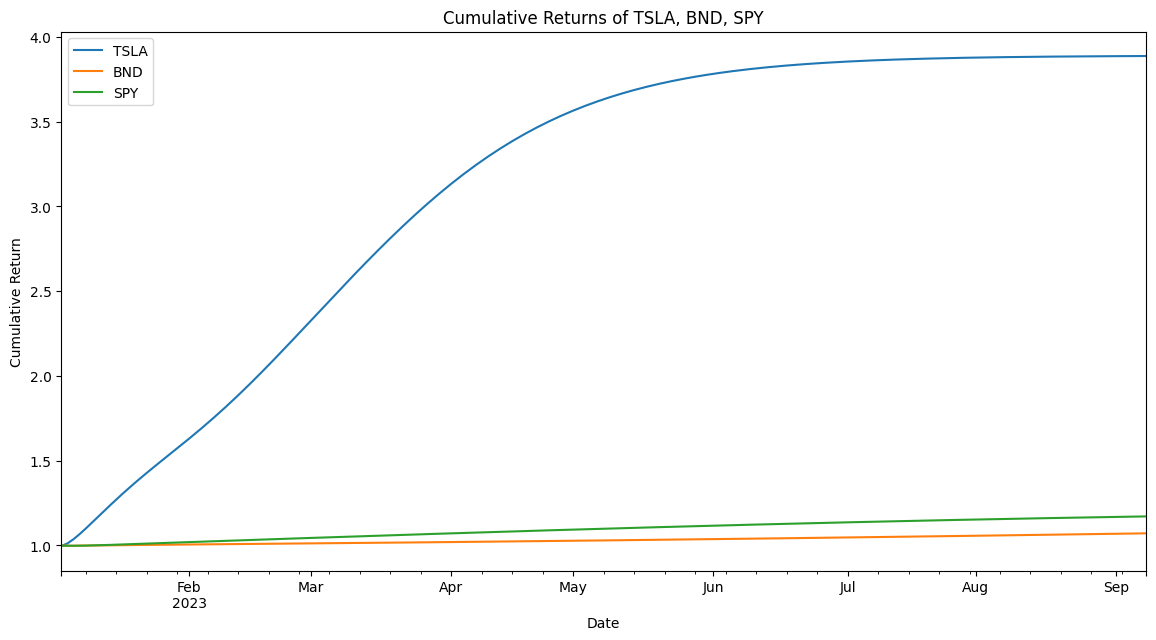

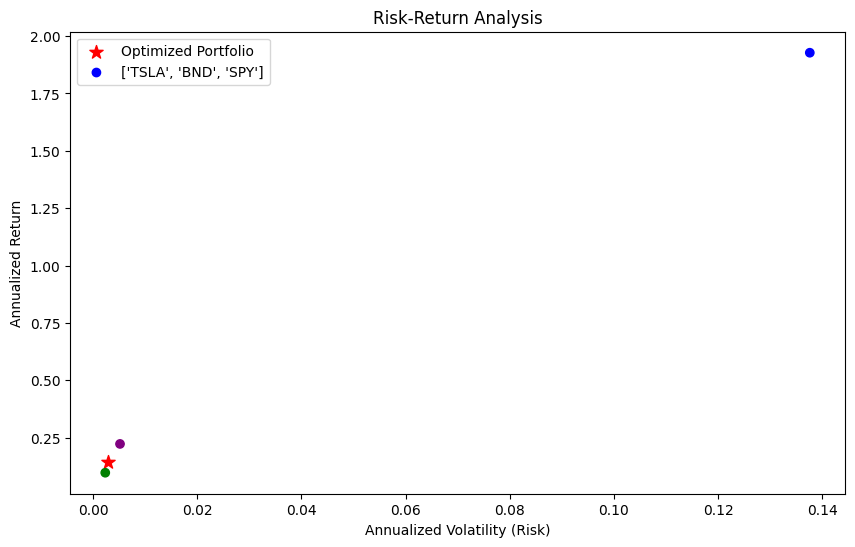

In [14]:
import matplotlib.pyplot as plt

# Cumulative Returns
cumulative_returns = (1 + daily_returns).cumprod()

# Plot cumulative returns
cumulative_returns.plot(figsize=(14, 7))
plt.title('Cumulative Returns of TSLA, BND, SPY')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.show()

# Risk-Return Scatter Plot
plt.figure(figsize=(10, 6))
plt.scatter(optimized_volatility, optimized_return, c='red', label='Optimized Portfolio', marker='*', s=100)
plt.scatter(daily_returns.std() * np.sqrt(252), annual_returns, c=['blue', 'green', 'purple'], label=['TSLA', 'BND', 'SPY'])
plt.xlabel('Annualized Volatility (Risk)')
plt.ylabel('Annualized Return')
plt.title('Risk-Return Analysis')
plt.legend()
plt.show()